Action2	(Arima)
资金流入流出预测
https://tianchi.aliyun.com/competition/entrance/231573/information
数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表
2.8万用户，284万行为数据，294天拆解利率，427天收益率
2013-07-01到2014-08-31，预测2014年9月的申购和赎回

1、说明解决方案思路（30points）
2、完成代码，使用时序或其他模型（40points）
3、提交结果Score > 120（30points）"	

说明解决方案思路:
1. 计算所有用户在测试集上每天的申购及赎回总额与实际情况总额的误差
2. 申购预测得分与 Purchasei 相关，赎回预测得分与 Redeemi 相关 , 误差与得分之间的计算公式不公布，但保证该计算公式为单调递减的，即误差越小，得分越高，误差与大，得分越低。当第 i 天的申购误差 Purchasei =0 ，这一天的得分为 10 分；当 Purchasei > 0.3 ，其得分为 0 
3. 最后公布总积分 = 申购预测得分 *45%+ 赎回预测得分 *55% 

# 数据探索

In [1]:
#数据加载,时间序列
import pandas
#parse_dates=['report_date']转换成日期类型
data = pandas.read_csv('./user_balance_table.csv', parse_dates=['report_date']) 
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [2]:
data.info()
#total_purchase_amt
#total_redeem_amt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   report_date          datetime64[ns]
 2   tBalance             int64         
 3   yBalance             int64         
 4   total_purchase_amt   int64         
 5   direct_purchase_amt  int64         
 6   purchase_bal_amt     int64         
 7   purchase_bank_amt    int64         
 8   total_redeem_amt     int64         
 9   consume_amt          int64         
 10  transfer_amt         int64         
 11  tftobal_amt          int64         
 12  tftocard_amt         int64         
 13  share_amt            int64         
 14  category1            float64       
 15  category2            float64       
 16  category3            float64       
 17  category4            float64       
dtypes: datetime64[ns](1), float64(4), int64(13)
memory usage: 390.

In [3]:
#聚合
total_balance = data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


In [4]:
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]
redeem

,total_redeem_amt
report_date,
2013-07-01,5525022
2013-07-02,2554548
2013-07-03,5953867
2013-07-04,6410729
2013-07-05,2763587
...,...
2014-08-27,468164147
2014-08-28,297893861
2014-08-29,273756380


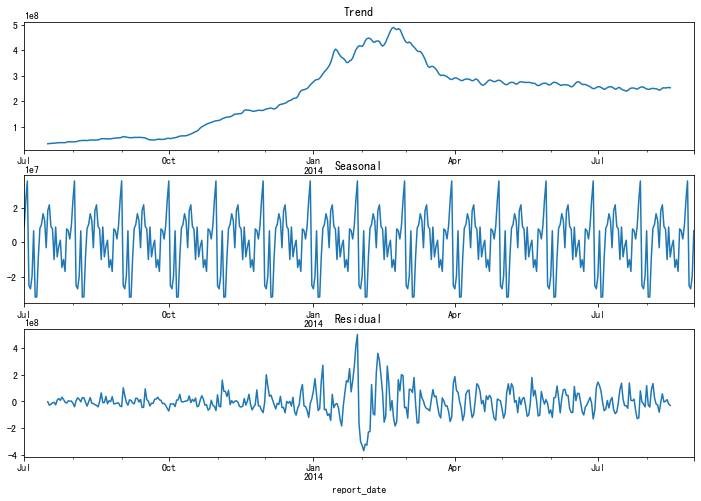

In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
#制定区间范围内的数据进行可视化
def plot_stl(data):
    #STL返回三个部分:trend(趋势),seasonal(季节),residual(残差)
    result =  sm.tsa.seasonal_decompose(data,period=30)#以月为单位
    #可视化
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    result.trend.plot(ax=ax1,title = 'Trend')
    result.seasonal.plot(ax=ax2,title = 'Seasonal')
    result.resid.plot(ax=ax3,title = 'Residual')

plot_stl(purchase.total_purchase_amt)

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


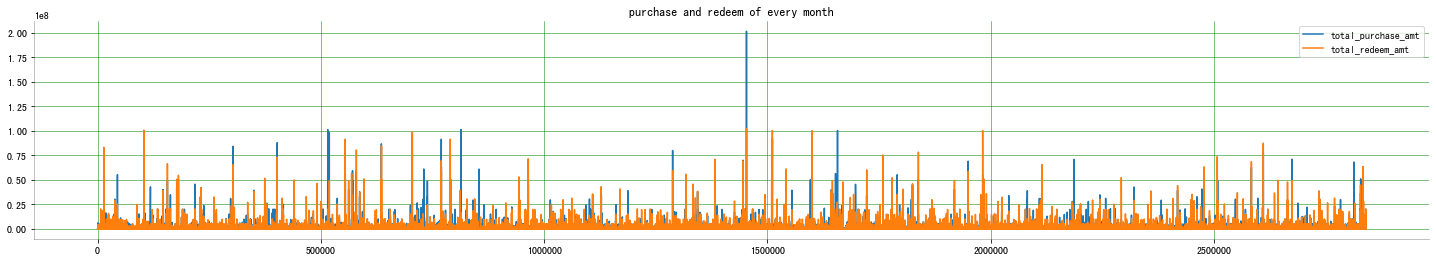

In [6]:
#可视化展示
plt.rcParams['figure.figsize'] = (25, 4.0)  # set figure size

data[['total_purchase_amt', 'total_redeem_amt']].plot()
plt.grid(True, linestyle="-", color="green", linewidth="0.5")
plt.legend()
plt.title('purchase and redeem of every month')

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.show()

In [9]:
purchase2 = purchase[(purchase.index>='2014-04-1') & (purchase.index<='2014-05-30')]
purchase2

,total_purchase_amt
report_date,
2014-04-01,453320585
2014-04-02,355347118
2014-04-03,363877120
2014-04-04,251895894
2014-04-05,202336542
2014-04-06,129477254
2014-04-07,196936223
2014-04-08,354770149
2014-04-09,383347565


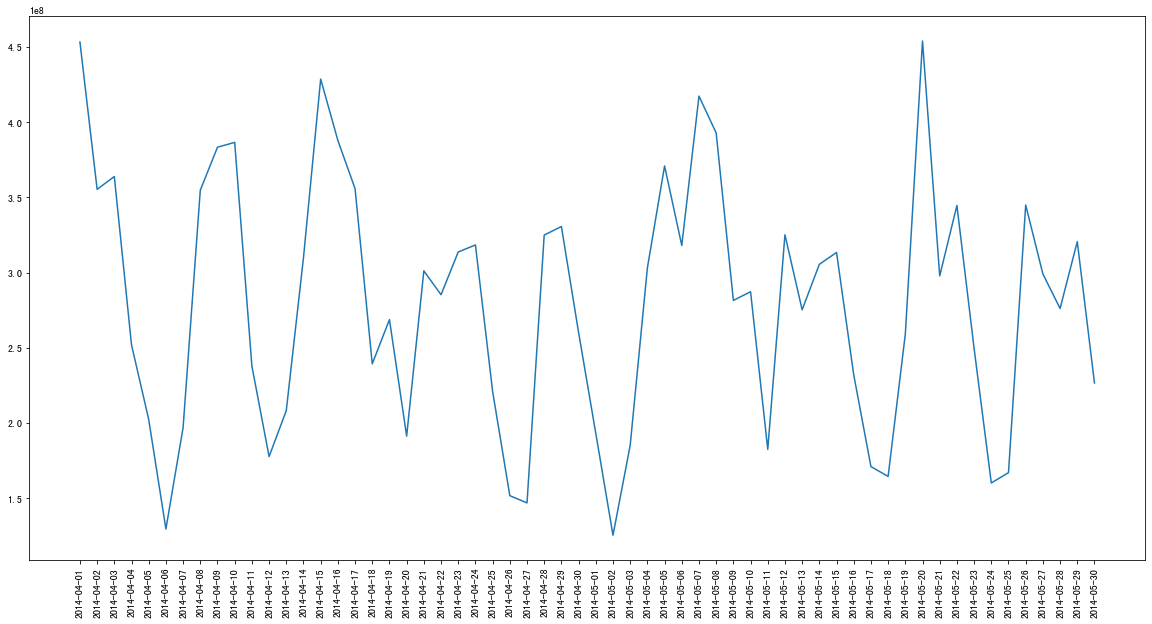

In [10]:
import pandas as pd
#走势图
plt.figure(figsize=(20,10))
plt.plot(purchase2.total_purchase_amt)
date_range = pd.date_range('2014-04-01','2014-05-30')
plt.xticks(date_range,rotation=90)
plt.show()

#根据走势图,猜测跟假期有关,后期可以对假期也做特征处理

In [11]:
#看时间序列的平稳性
from statsmodels.tsa.stattools import adfuller
t=adfuller(purchase['total_purchase_amt'])
t

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [13]:
#如何确定该序列能否平稳：
#主要看1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，如果ADF Test result同时小于1%、5%、10%即说明非常好地拒绝原假设（原假设是不稳定的，因此证明是平稳的）
#不能拒绝原假设(不平稳)
#一阶差分
diff1 = purchase.diff(1)
t=adfuller(diff1[1:])#[1:]去掉空值
t

(-7.947102224652343,
 3.198186862488185e-12,
 18,
 407,
 {'1%': -3.4465195891135845,
  '5%': -2.8686676281678634,
  '10%': -2.5705668101226085},
 15918.844657651942)

In [16]:
t2=adfuller(redeem['total_redeem_amt'])
diff2 = redeem.diff(1)
t2=adfuller(diff2[1:])#[1:]去掉空值
t2

(-11.69198690696884,
 1.6443717458497645e-21,
 12,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15779.04993673871)

In [25]:
from statsmodels.tsa.arima_model import ARIMA
#p,d,q,其中d = 1
model = ARIMA(purchase,order = (7,1,5)).fit()
#typ='levels'对原始数据维度进行预测,相当于反差分
purchase_pred = model.predict('2014-09-01','2014-09-30',typ='levels')
purchase_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2014-09-01    3.310539e+08
2014-09-02    3.318762e+08
2014-09-03    3.338910e+08
2014-09-04    2.983191e+08
2014-09-05    2.407509e+08
2014-09-06    2.266140e+08
2014-09-07    2.435554e+08
2014-09-08    2.970865e+08
2014-09-09    3.321274e+08
2014-09-10    3.265197e+08
2014-09-11    2.916841e+08
2014-09-12    2.392702e+08
2014-09-13    2.253550e+08
2014-09-14    2.475289e+08
2014-09-15    2.950936e+08
2014-09-16    3.345010e+08
2014-09-17    3.280818e+08
2014-09-18    2.927099e+08
2014-09-19    2.448967e+08
2014-09-20    2.275711e+08
2014-09-21    2.530230e+08
2014-09-22    2.980719e+08
2014-09-23    3.366748e+08
2014-09-24    3.321948e+08
2014-09-25    2.947106e+08
2014-09-26    2.505384e+08
2014-09-27    2.318269e+08
2014-09-28    2.574471e+08
2014-09-29    3.025702e+08
2014-09-30    3.387019e+08
Freq: D, dtype: float64

In [20]:
model2 = ARIMA(redeem,order = (7,1,5)).fit()
#typ='levels'对原始数据维度进行预测,相当于反差分
redeem_pred = model2.predict('2014-09-01','2014-09-30',typ='levels')
redeem_pred

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2014-09-01    3.169090e+08
2014-09-02    3.372455e+08
2014-09-03    3.632442e+08
2014-09-04    3.074694e+08
2014-09-05    2.628057e+08
2014-09-06    2.258706e+08
2014-09-07    2.592158e+08
2014-09-08    3.115468e+08
2014-09-09    3.477437e+08
2014-09-10    3.562431e+08
2014-09-11    3.092719e+08
2014-09-12    2.598512e+08
2014-09-13    2.339112e+08
2014-09-14    2.578186e+08
2014-09-15    3.125493e+08
2014-09-16    3.537239e+08
2014-09-17    3.573622e+08
2014-09-18    3.146179e+08
2014-09-19    2.626592e+08
2014-09-20    2.387440e+08
2014-09-21    2.616172e+08
2014-09-22    3.157165e+08
2014-09-23    3.588117e+08
2014-09-24    3.611535e+08
2014-09-25    3.197931e+08
2014-09-26    2.672031e+08
2014-09-27    2.432839e+08
2014-09-28    2.661170e+08
2014-09-29    3.197114e+08
2014-09-30    3.635485e+08
Freq: D, dtype: float64

In [21]:
model.aic

16669.646033929606

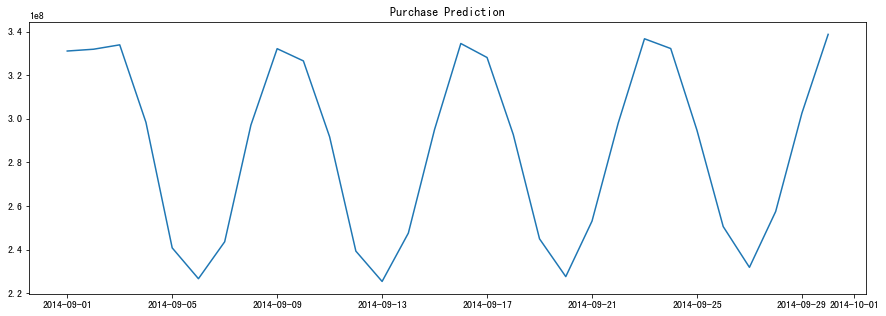

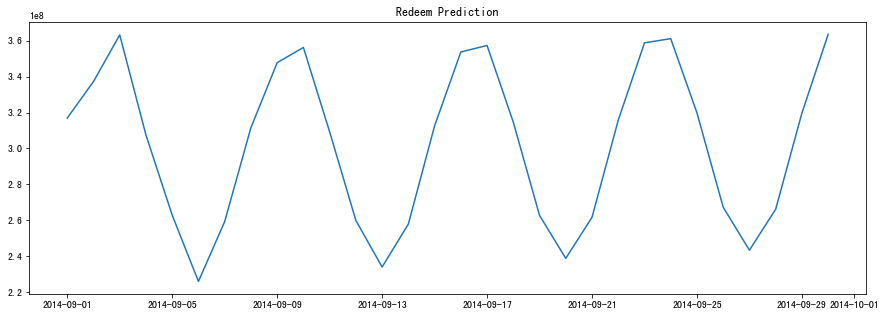

In [26]:
#可视化
plt.figure(figsize=(15,5))
plt.title('Purchase Prediction')
plt.plot(purchase_pred)
plt.show()

plt.figure(figsize=(15,5))
plt.title('Redeem Prediction')
plt.plot(redeem_pred)
plt.show()

In [27]:
result = pd.DataFrame()
result['date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values
result

,date,purchase,redeem
0,2014-09-01,3.310539e+08,3.169090e+08
1,2014-09-02,3.318762e+08,3.372455e+08
2,2014-09-03,3.338910e+08,3.632442e+08
3,2014-09-04,2.983191e+08,3.074694e+08
4,2014-09-05,2.407509e+08,2.628057e+08
5,2014-09-06,2.266140e+08,2.258706e+08
6,2014-09-07,2.435554e+08,2.592158e+08
7,2014-09-08,2.970865e+08,3.115468e+08
8,2014-09-09,3.321274e+08,3.477437e+08
9,2014-09-10,3.265197e+08,3.562431e+08


In [29]:
result['date'] = result['date'].apply(lambda x:str(x).replace('-','')[0:8])#日期格式去掉-
result

,date,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08


In [31]:
result.to_csv('arima.csv',header=None,index=False)#提交查看成绩

finalScore:100.9975